# CLASIFICACIÓN DE RIPPLES


-Algoritmo basado en aprendizaje supervisado (SVM) para la detección  de "ripples", LFPs o picos de actividad cerebral en las
series temporales registradas por 8 delectrodos localizados en el hipotálamo de un ser humano. Para más información
https://thebraincodegames.github.io/ .

-Cada dispositivo registra un valor de potencial eléctrico cada (1/30.000) s. Al valor del denominador se le conoce como
"frecuencia de sampleo".

-Para "alimentar" los datos recabados a nuestro algoritmo se han dividido los muestreos en segmentos de "A" instantes.
Cabe recordar que un instante cada 1/30.000 segundos, luego los segmentos tendrán una duración de A/30.000 segundos.
El algoritmo evalua cada segmento en base a sus A instantes, para decidir si contiene o no un ripple.
A este conjunto de segmentos que constituyen el "input" de nuestro algoritmo, se ha referenciado como 'X'.

-Para determinar el valor óptimo del ancho del segmento, el hiperparámetro "A", se han compararon los resultados 
del algoritmo para distintos valores situados entre el periodo de oscilación de un "ripple" y la duración media de uno.

-Dado que se trata de aprendizaje supervisado, se necesita un conjunto de etiquetas elaboradas por un experto que informen
al algoritmo durante su aprendizaje sobre lo que es y no es un ripple. A este conjunto de etiquetas, se ha referenciado como 'y'.

# IMPORTACIONES


# FUNCIONES AUXILIARES

In [1]:
import numpy as np
import pickle
import sklearn as sk
from sklearn import svm
from sklearn import calibration
import imblearn
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from metrics import compute_precision_recall_events

In [18]:
def split_data(x,y,window_dur=60,fs=1250,split=0.7,window=1):
    n_samples_window=window_dur*fs
    n_windows=np.shape(x)[0]//n_samples_window
    x_test=[]
    x_train=[]
    y_train=[]
    y_test=[]
    rand_arr= np.random.rand(n_windows)         # Distribución normal, quizá no sea lo más correcto
    #print(rand_arr)
    for i in range(n_windows):
        if rand_arr[i]>=split:
            x_test=np.append(x_test,x[i*n_samples_window:(i+1)*n_samples_window])
            y_test=np.append(y_test,y[i*n_samples_window:(i+1)*n_samples_window])
        else:
            x_train=np.append(x_train,x[i*n_samples_window:(i+1)*n_samples_window])
            y_train=np.append(y_train,y[i*n_samples_window:(i+1)*n_samples_window])
    if window==1:       
        x_test=np.reshape(x_test,(-1,8))
        x_train=np.reshape(x_train,(-1,8))
        y_test=np.reshape(y_test,(-1,1))
        y_train=np.reshape(y_train,(-1,1))
    else:
        x_test=np.reshape(x_test,(-1,window*8))
        x_train=np.reshape(x_train,(-1,window*8))
        y_test=np.reshape(y_test,(-1,window))
        y_train=np.reshape(y_train,(-1,window))
    return x_test,y_test,x_train,y_train

In [16]:
def rec_signal(y):
    len=np.shape(y)[0]
    print(np.shape(y))
    r_signal=np.empty(shape=(len))
    for i,w in enumerate(y):
        if any(w)==1:
            r_signal[i]=1
    return r_signal

In [32]:
# Carga de datos ya z-scoreados y subsampleados
with open('C:\ProyectoInicial\Datos_pickle\\x_Amigo2_1.pickle', 'rb') as handle:
    x=pickle.load(handle)
with open('C:\ProyectoInicial\Datos_pickle\\x_Som_2.pickle', 'rb') as handle:
    x=np.append(x,pickle.load(handle))
with open('C:\ProyectoInicial\Datos_pickle\\y_Amigo2_1.pickle', 'rb') as handle:
    y=pickle.load(handle)
with open('C:\ProyectoInicial\Datos_pickle\\y_Som_2.pickle', 'rb') as handle:
    y=np.append(y,pickle.load(handle)) 
x=np.reshape(x,(-1,8))
y=np.reshape(y,(-1,1))

fs=1250
window=1

x_test,y_test_aux,x_train,y_train_aux=split_data(x,y,window_dur=60,fs=fs,split=0.7,window=window)
if window==1:
    y_train=np.reshape(y_train_aux,(-1,))
    y_test=np.reshape(y_test_aux,(-1,))
else:
    y_train=rec_signal(y_train_aux)
    y_test=rec_signal(y_test_aux)

print(np.shape(x_train),np.shape(x_test))

print(np.shape(y_train),np.shape(y_test))


(3075000, 8) (1200000, 8)
(3075000,) (1200000,)


In [9]:
print(x[40:80,:])
aco=x_test[0:2,:,:]

[[-1.1914e+00 -1.1621e+00 -9.7168e-01 -1.1123e+00 -1.3320e+00 -1.2861e+00
  -1.0488e+00 -1.1914e+00]
 [-1.2402e+00 -1.3330e+00 -1.2031e+00 -1.4443e+00 -1.3906e+00 -1.2412e+00
  -1.2334e+00 -1.1406e+00]
 [-1.4834e+00 -1.4355e+00 -1.5312e+00 -1.5918e+00 -1.4658e+00 -1.6309e+00
  -1.4648e+00 -1.3613e+00]
 [-2.1484e+00 -2.3594e+00 -2.5566e+00 -2.0898e+00 -2.4355e+00 -2.0098e+00
  -1.8574e+00 -1.6553e+00]
 [-1.4512e+00 -1.4570e+00 -1.1230e+00 -1.5449e+00 -1.4150e+00 -1.7578e+00
  -1.4414e+00 -1.4678e+00]
 [-1.4375e+00 -1.4795e+00 -1.0928e+00 -1.4404e+00 -1.4834e+00 -1.5391e+00
  -1.5078e+00 -1.4688e+00]
 [-1.3867e+00 -1.4873e+00 -1.2197e+00 -1.4170e+00 -1.3672e+00 -1.5820e+00
  -1.4102e+00 -1.3564e+00]
 [-1.3564e+00 -1.4775e+00 -1.2197e+00 -1.1992e+00 -1.4082e+00 -1.4951e+00
  -1.0674e+00 -1.2070e+00]
 [-1.1758e+00 -1.2822e+00 -8.2422e-01 -9.9512e-01 -1.0986e+00 -1.0996e+00
  -1.0000e+00 -9.4629e-01]
 [-8.3643e-01 -7.7197e-01 -7.0166e-01 -8.0566e-01 -7.1631e-01 -8.4277e-01
  -7.7002e-01 -6.

In [33]:
rus = RandomUnderSampler(sampling_strategy=0.1)
# Nº de instantes con ripple: 78588
x_train_us, y_train_us, = rus.fit_resample(x_train, y_train)

In [26]:
def get_predictions_index(predictions,threshold=0.5):
    aux=np.copy(predictions)
    aux[aux>=threshold]=1
    aux[aux<threshold]=0
    pred_indexes =[]
    dif=np.diff(aux,axis=0)
    for i_pred,pred in enumerate(dif):
        if pred==1:
            pred_indexes.append(i_pred)
        elif pred==-1:
            pred_indexes.append(i_pred)
    if len(pred_indexes)%2==1:
        pred_indexes=pred_indexes[:-1]    
    pred_indexes=np.array(pred_indexes).reshape(-1,2)
    return(np.array(pred_indexes).reshape(-1,2))

In [34]:
#clf = svm.LinearSVC(verbose=True,probability=True)
clf = sk.calibration.CalibratedClassifierCV(svm.LinearSVC()) 
if window==1:
    clf.fit(x_train_us, y_train_us)
else:
    clf.fit(x_train, y_train)

with open('C:\ProyectoInicial\Otros_modelos\SVM\modelos\M_L_NW_US_01.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\adrub\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\adrub\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\adrub\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\adrub\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed t

In [9]:
with open('C:\ProyectoInicial\Otros_modelos\SVM\modelos\M_L_US_01.pickle', 'rb') as handle:
    clf=pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\ProyectoInicial\\Otros_modelos\\SVM\\modelos\\M_L_US_01.pickle'

In [35]:
y_pred_train = clf.predict_proba(x_train)

(array([2585719.,  293237.,   80313.,   36719.,   21871.,   14766.,
          11127.,    9098.,    8101.,   14049.]),
 array([6.40442274e-06, 1.00005763e-01, 2.00005123e-01, 3.00004482e-01,
        4.00003841e-01, 5.00003200e-01, 6.00002559e-01, 7.00001918e-01,
        8.00001277e-01, 9.00000636e-01, 9.99999995e-01]),
 <BarContainer object of 10 artists>)

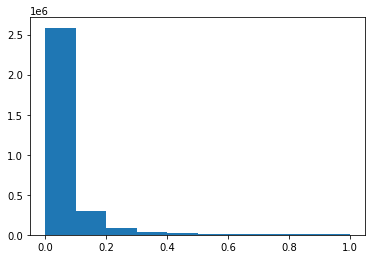

In [36]:
plt.hist(y_pred_train[:,1])

In [38]:
def perf_array(y,y_gt):
    # He observado que la mejor F1 siempre sale con th1=0.05 y th2=0.4
    tharr=np.linspace(0.11,0.99,9)
    '''th1arr=np.array([0.05])
    th2arr=np.array([0.6])'''
    performances=[]
    y_gt_ind=get_predictions_index(y_gt)
    for th in tharr:
        print(th)
        y_pred_ind=get_predictions_index(y,th)
        prec,rec,F1,a,b,c=compute_precision_recall_events(y_pred_ind,y_gt_ind,0)
        performances=np.append(performances,[th,prec,rec,F1])
    performances=np.reshape(performances,(-1,4))
    return performances

In [39]:
prob_arr_train = clf.predict_proba(x_train)
prob_train=prob_arr_train[:,1]
if window!=1:
    y_pred_train=np.empty(shape=(np.shape(prob_arr_train)[0]*window,1,1))
    for i,val in enumerate(prob_train):
            y_pred_train[i*window:(i+1)*window]=val
else:
    y_pred_train=prob_train
perf=perf_array(y_pred_train,y_train)
best_performance=perf[np.argmax(perf[:,3]),:]

prob_arr_test = clf.predict_proba(x_test)
prod_test=prob_arr_test[:,1]

if window!=1:
    y_pred_test=np.empty(shape=(np.shape(prob_arr_test)[0]*window,1,1))
    for i,val in enumerate(prob_train):
            y_pred_test[i*window:(i+1)*window]=val
else:
    y_pred_test=prod_test

y_gt_ind_test=get_predictions_index(y_test)

y_pred_ind_test=get_predictions_index(y_pred_test,best_performance[0])
P_test,R_test,F1_test,a,b,c=compute_precision_recall_events(y_pred_ind_test,y_gt_ind_test,0)
best_performance=np.append(best_performance,[P_test,R_test,F1_test,best_performance[-1]/F1_test])


0.11
precision = 0.052318443667957314
recall = 0.9961744452945677
F1 = 0.09941564153319742
0.22
precision = 0.1327599514830742
recall = 0.9701606732976281
F1 = 0.23355893619885684
0.33
precision = 0.2178880766631857
recall = 0.936495791889824
F1 = 0.3535241135235435
0.44
precision = 0.30113071008593395
recall = 0.8859984697781178
F1 = 0.44949000136596623
0.55
precision = 0.3821623681870156
recall = 0.8255547054322877
F1 = 0.5224666408837867
0.66
precision = 0.4721978600245571
recall = 0.75592960979342
F1 = 0.5812887551917642
0.77
precision = 0.5770015298317185
recall = 0.6656465187452181
F1 = 0.6181622545224941
0.88
precision = 0.676027676027676
recall = 0.5455241009946442
F1 = 0.6038047623514824
0.99
precision = 0.8744650499286734
recall = 0.23565416985462895
F1 = 0.37125982819764847
precision = 0.5602879424115177
recall = 0.731006160164271
F1 = 0.6343619730804819


In [40]:
results = {
"performance": best_performance,
"predictions": 0,
}

to_save={'results': results,
'params': "SVM",
}
# Store data (serialize): un archivo para cada bucle de entrenamiento
with open('C:\ProyectoInicial\Otros_modelos\SVM\SVM_train.pickle', 'wb') as handle:
 pickle.dump(to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)